# Scikit Learn & Keras Text Classifier Pipeline with Word2Vec Featurization

### This notebook shows how to train pipelines for word embeddigns and scikit classifier

The pipeline takes as input a dataframe containing tweets in a text column, a word embedding file, and trains a scikit learn model. The modeling pipeline is then saved to a .zip file. This file can be loaded later and used for prediction and evaluation of new data sets.

In [1]:
import os

working_dir = r"C:\\Users\\remoteuser\\Desktop\\Data\\Sentiment140_Classification"

## Set training and test files
training_tweet_filename = os.path.join(working_dir, 'training_text.csv')
training_label_filename = os.path.join(working_dir, 'training_label.csv')
test_tweet_filename = os.path.join(working_dir, 'testing_text.csv')
test_label_filename = os.path.join(working_dir, 'testing_label.csv')

## Set word2vec file, parameter file for model, and model pipeline file
w2v_embeddings_filename = os.path.join(working_dir, 'w2vec.txt')
params_file_path = os.path.join(working_dir, "params.tsv")
sklearn_model_file = os.path.join(working_dir, 'sk_model.zip') 
keras_model_file = os.path.join(working_dir, 'keras_model.zip') 

In [2]:
from tatk.feature_extraction.word2vec_vectorizer import Word2VecVectorizer

from __future__ import absolute_import
from __future__ import division
import tatk
import collections
import math
import sys
import random
import numpy as np
from six.moves import urllib
from six.moves import xrange  
from timeit import default_timer as timer
import pandas as pd
import re
import io
from nltk.tokenize import TweetTokenizer
import num2words

import math
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tatk.pipelines.text_classification.text_classifier import TextClassifier
from tatk.pipelines.text_classification.keras_text_classifier import KerasTextClassifier
from tatk.feature_extraction.callable_vectorizer import CallableVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 

!pip show azureml-tatk

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Name: azureml-tatk
Version: 0.1.18123.2b3
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
License: UNKNOWN
Location: c:\users\remoteuser\appdata\local\amlworkbench\python\lib\site-packages
Requires: scipy, pandas, dill, gensim, qgrid, sklearn-crfsuite, pyspark, numpy, pdfminer.six, azure-ml-api-sdk, scikit-learn, lxml, azure-storage, h5py, ipython, nose, requests, keras, matplotlib, validators, unidecode, bqplot, jsonpickle, ipywidgets, ruamel.yaml, pytest, nltk, docker
Required-by: 


## Load and preprocess tweet data

### Define data loading the preprocessing functions for tweets

In [3]:
# Data processing
# In the following code, we replace Emails, URLS, emoticons etc with special labels
pos_emoticons=["(^.^)","(^-^)","(^_^)","(^_~)","(^3^)","(^o^)","(~_^)","*)",":)",":*",":-*",":]",":^)",":}",
               ":>",":3",":b",":-b",":c)",":D",":-D",":O",":-O",":o)",":p",":-p",":P",":-P",":Þ",":-Þ",":X",
               ":-X",";)",";-)",";]",";D","^)","^.~","_)m"," ~.^","<=8","<3","<333","=)","=///=","=]","=^_^=",
               "=<_<=","=>.<="," =>.>="," =3","=D","=p","0-0","0w0","8D","8O","B)","C:","d'-'","d(>w<)b",":-)",
               "d^_^b","qB-)","X3","xD","XD","XP","ʘ‿ʘ","❤","💜","💚","💕","💙","💛","💓","💝","💖","💞",
               "💘","💗","😗","😘","😙","😚","😻","😀","😁","😃","☺","😄","😆","😇","😉","😊","😋","😍",
               "😎","😏","😛","😜","😝","😮","😸","😹","😺","😻","😼","👍"]

neg_emoticons=["--!--","(,_,)","(-.-)","(._.)","(;.;)9","(>.<)","(>_<)","(>_>)","(¬_¬)","(X_X)",":&",":(",":'(",
               ":-(",":-/",":-@[1]",":[",":\\",":{",":<",":-9",":c",":S",";(",";*(",";_;","^>_>^","^o)","_|_",
               "`_´","</3","<=3","=/","=\\",">:(",">:-(","💔","☹️","😌","😒","😓","😔","😕","😖","😞","😟",
               "😠","😡","😢","😣","😤","😥","😦","😧","😨","😩","😪","😫","😬","😭","😯","😰","😱","😲",
               "😳","😴","😷","😾","😿","🙀","💀","👎"]

emoticonsDict = {}
for i,each in enumerate(pos_emoticons):
    emoticonsDict[each]=' POS_EMOTICON_'+num2words.num2words(i).upper()+' '
    
for i,each in enumerate(neg_emoticons):
    emoticonsDict[each]=' NEG_EMOTICON_'+num2words.num2words(i).upper()+' '
    
# use these three lines to do the replacement
rep = dict((re.escape(k), v) for k, v in emoticonsDict.items())
emoticonsPattern = re.compile("|".join(rep.keys()))

# Read in files
def read_tweets(filename):
    """Read the raw tweet data from a file. Replace Emails etc with special tokens """
    with open(filename, 'r') as f:
        all_lines=f.readlines()
        padded_lines=[]
        for line in all_lines:
            line = emoticonsPattern.sub(lambda m: rep[re.escape(m.group(0))], line.lower().strip())
            line=re.sub(r'(.)\1{2,}', r'\1\1',line)
            words_tokens=[token for token in TweetTokenizer().tokenize(line)]                    
            line= ' '.join(token for token in words_tokens )         
            padded_lines.append(line)
    return padded_lines

### Read in tweet training data and training labels, and combine into one data-frame

In [4]:
## Read in tweet file. Labels are 4 and 0 (4 being positive and 0 being negative)
tweets = read_tweets(training_tweet_filename)

with open(training_label_filename, 'r') as f:
    all_lines=f.readlines()
    tweet_labels = []
    for line in all_lines:
        line = line.strip()
        label = 0
        if line == '4':
            label = 1
        #else:
        #    label = 'negative'
        tweet_labels.append(label)

df = pd.DataFrame({'raw_tweets':tweets, 'labels':tweet_labels}, columns=['raw_tweets','labels'])
display(df[:3])

,raw_tweets,labels
0,going to fort smith today . stoked for the res...,1
1,argh .. omniture discover 2 is annoying me ..,0
2,@colinloretz hah ! thanks colin .,1


In [5]:
## Count the labels in training set
df['labels'].value_counts()

0    640152
1    639848
Name: labels, dtype: int64

### Use CallableVectorizer to pre-process tweets in a given dataframe
#### This takes raw tweets and further processes them to generate processed tweets which are used to run training / testing

In [6]:
# Define functions wihch are to be used to pre-process tweets
def to_lower_case(x):
    return x.lower()

def emailsReplace(x):
    return x.replace(r'[\w\.-]+@[\w\.-]+', ' EMAIL ')

def numsReplace(x):
    return x.replace(r'[\w\.-]+@[\w\.-]+', ' NUM ')

def userMentionsReplace(x):
    return x.replace(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)', ' USER ')

def urlReplace(x):
    return x.replace(r'r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+', ' URL ')

def punctuationReplace(x):
    return x.replace(r'(?<=\w)[^\s\w](?![^\s\w])', ' PUN ')

def atReplace(x):
    return x.replace(r'@', ' AT ')

# Chain functions into a list
featFuncs=[to_lower_case, emailsReplace, numsReplace, userMentionsReplace, urlReplace, punctuationReplace, atReplace]

# Create a transformer specifying functions, 
callable = CallableVectorizer(input_col="raw_tweets", output_col="tweets", feat_list=featFuncs, preprocessor = True)
processed_df = callable.tatk_fit_transform(df)

processed_df.head(3)


CallableVectorizer::tatk_fit_transform ==> start
CallableVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.1 mins


,raw_tweets,labels,tweets
0,going to fort smith today . stoked for the res...,1,going to fort smith today . stoked for the res...
1,argh .. omniture discover 2 is annoying me ..,0,argh .. omniture discover 2 is annoying me ..
2,@colinloretz hah ! thanks colin .,1,AT colinloretz hah ! thanks colin .


In [7]:
processed_df[['tweets','labels']].head(3)

,tweets,labels
0,going to fort smith today . stoked for the res...,1
1,argh .. omniture discover 2 is annoying me ..,0
2,AT colinloretz hah ! thanks colin .,1


### Split data into training and validation

In [8]:
train, valid = train_test_split(df, test_size=0.33)
train.head(3)

,raw_tweets,labels,tweets
1186081,""" @glamorousvandal sure come within 10 days , ...",0,""" AT glamorousvandal sure come within 10 days..."
970629,is listening to my music now as i cant stand h...,1,is listening to my music now as i cant stand h...
640576,totally nothing,0,totally nothing


## Scikit learn text classification pipeline

### Define scikit learn pipeline

In [9]:
from sklearn.model_selection import ParameterGrid
#params = {'tol': [0.0001, 0.001], 'max_iter': [5, 10]}

## Define classifier from scikit learn
log_reg_learner =  LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                            C=1.0, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=None, 
                            solver='lbfgs', max_iter=10, 
                            verbose=1, warm_start=True, n_jobs=3) 

# Train the model on tweets
text_classifier = TextClassifier(embedding_file_path = w2v_embeddings_filename,
                                estimator=log_reg_learner, 
                                extract_word_ngrams=False,
                                text_cols = ["tweets"], 
                                label_cols = ["labels"])

## Export parameters of the model
text_classifier.export_params(params_file_path)

TextClassifier::create_pipeline ==> start
:: number of jobs for the pipeline : 6
0	tweets_nltk_preprocessor
1	tweets_word2vec
2	assembler
3	learner
TextClassifier::create_pipeline ==> end


### Fit classifier on training data

In [10]:
text_classifier.fit(train)

TextClassifier::fit ==> start
schema: col=raw_tweets:TX:0 col=labels:I8:1 col=tweets:TX:2 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.32 mins
Word2VecVectorizer::tatk_fit_transform ==> start
Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 1.42 mins
VectorAssembler::transform ==> start, num of input records=857600
(857600, 50)
all_features::
(857600, 50)
Time taken: 0.01 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_fit ==> start


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    9.3s finished


LogisticRegression::tatk_fit ==> end 	 Time taken: 0.17 mins
Time taken: 1.92 mins
TextClassifier::fit ==> end


TextClassifier(add_index_col=False, callable_proprocessors_list=None,
        cat_cols=None, char_hashing_original=False, col_prefix='tmp_00_',
        decompose_n_grams=False, detect_phrases=False,
        dictionary_categories=None, dictionary_file_path=None,
        embedding_file_path='C:\\\\Users\\\\remoteuser\\\\Desktop\\\\Data\\\\Sentiment140_Classification\\w2vec.txt',
        embedding_file_path_fastText=None, estimator=None,
        estimator_vectorizers_list=None, extract_char_ngrams=False,
        extract_word_ngrams=False, label_cols=['labels'],
        numeric_cols=None, pos_tagger_vectorizer=False,
        preprocessor_dictionary_file_path=None, regex_replcaement='',
        replace_regex_pattern=None, scale_numeric_cols=False,
        text_callable_list=None, text_cols=['tweets'],
        text_regex_list=None, weight_col=None)

### Save the scikit learn training pipleine

In [11]:
text_classifier.save(sklearn_model_file)

BaseTextModel::save ==> start
TatkPipeline::save ==> start
copy embedding file from  C:\\Users\\remoteuser\\Desktop\\Data\\Sentiment140_Classification\w2vec.txt
Time taken: 0.0 mins
TatkPipeline::save ==> end
Time taken: 0.06 mins
BaseTextModel::save ==> end


### Load and the training pipleine, predict and evaluate the accuracy on held-out validation set

In [53]:
text_classifier_reloaded = TextClassifier.load(sklearn_model_file)

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word2VecVectorizer: Word2Vec model loaded from C:\\Users\\remoteuser\\Desktop\\Data\\Sentiment140_Classification\sk_model.zip 2018-05-31 06.19.09\sk_model\pipeline\tweets_word2vec\embedding_table.txt
Time taken: 0.06 mins
TatkPipeline::load ==> end
Time taken: 0.07 mins
BaseTextModel::load ==> end


In [55]:
predicted_df = text_classifier_reloaded.predict(valid)
display(predicted_df[:3])

TextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.16 mins
Word2VecVectorizer::tatk_transform ==> start
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.7 mins
VectorAssembler::transform ==> start, num of input records=422400
(422400, 50)
all_features::
(422400, 50)
Time taken: 0.01 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_predict_proba ==> start
LogisticRegression::tatk_predict_proba ==> end 	 Time taken: 0.03 mins
LogisticRegression::tatk_predict ==> start
LogisticRegression::tatk_predict ==> end 	 Time taken: 0.03 mins
Time taken: 0.93 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,tweets,labels,probabilities,prediction
518808,AT kt_93 hehe i know,1,"[0.27810977456126795, 0.721890225438732]",1
166749,AT katiecorless bollocks . i would of loved t...,0,"[0.4726533465040218, 0.5273466534959782]",1
840126,AT porceleindoll come to wa and i'll help you...,1,"[0.12090388768582727, 0.8790961123141727]",1


TextClassifier ::evaluate ==> start
Time taken: 0.02 mins
TextClassifier ::evaluate ==> end
TextClassifier ::evaluate ==> start
Time taken: 0.02 mins
TextClassifier ::evaluate ==> end
Confusion matrix, without normalization


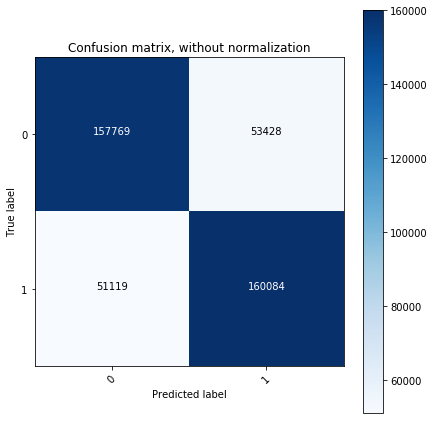

0.7524928200298536

In [56]:
text_classifier_reloaded.evaluate(valid)

evaluations = text_classifier_reloaded.evaluate(valid)
evaluations.plot_confusion_matrix(normalize=False,
                                title='Confusion matrix, without normalization', 
                                print_confusion_matrix=False,
                                figsize=(6,6),
                                colors=None)
evaluations.get_metrics('micro_avg_accuracy')
evaluations.get_metrics('macro_avg_accuracy')

## Keras classification pipeline

### Define keras classifier

In [21]:
from tatk.pipelines.text_classification.keras_embedding_text_classifier import KerasEmbeddingTextClassifier
keras_text_classifier = KerasEmbeddingTextClassifier(embedding_file_path=w2v_embeddings_filename, 
                                                     input_col="tweets", 
                                                     label_cols="labels",
                                                     model_type="CNN",
                                                     binary_format=False, 
                                                     callbacks=True)

KerasEmbeddingTextClassifier::create_pipeline ==> start
Word2VecVectorizer::load_embeddings ==> start
Time taken: 0.06 mins
Word2VecVectorizer::load_embeddings ==> end
num_words=69953
:: number of jobs for the pipeline : 6
0	nltk_preprocessor
1	vectorizer
2	learner
KerasEmbeddingTextClassifier::create_pipeline ==> end


In [22]:
# Set parameters
keras_text_classifier.set_step_params_by_name("learner", n_epochs = 10)
keras_text_classifier.set_step_params_by_name("learner", batch_size = 250)
keras_text_classifier.set_step_params_by_name("learner", validation_split = 0.2)

keras_text_classifier.set_step_params_by_name("learner", model__kernel_size=[3,4,5])
keras_text_classifier.set_step_params_by_name("learner", model__num_filters=25)
keras_text_classifier.set_step_params_by_name("learner", model__dropout_rate  = 0.5)
keras_text_classifier.set_step_params_by_name("learner", model__hidden_dims  = 100)

keras_text_classifier.set_step_params_by_name("vectorizer", get_from_path=False)

# Get parameters
keras_text_classifier.get_step_params_by_name("learner")

{'batch_size': 250,
 'callbacks_list': ['tensorboard', 'checkpoint', 'early'],
 'cuda_devices': '0',
 'feature_cols': ['features'],
 'input_padding_value': 69952,
 'label_cols': ['labels'],
 'log_path': 'C:\\Users\\remoteuser\\tatk\\resources\\logs',
 'max_len': None,
 'model__class_type': 'single-label',
 'model__dropout_rate': 0.5,
 'model__hidden_dims': 100,
 'model__init_wordvecs': array([[-1.03649604, -1.48352396, -1.07123899, ..., -0.95034897,
         -0.069777  , -0.046452  ],
        [ 0.082796  ,  0.90919   ,  0.30086401, ...,  0.24328201,
         -0.70956302,  0.70759702],
        [-0.845285  , -1.73459303, -1.39133   , ..., -0.99724901,
          0.093811  , -0.59610701],
        ...,
        [ 0.116024  , -0.15468501, -0.126646  , ...,  0.12105   ,
          0.037048  , -0.011772  ],
        [ 0.00430944,  0.03613211, -0.04568701, ..., -0.01723733,
         -0.16511534,  0.01022116],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  

### Fit Keras classifier 

In [23]:
keras_text_classifier.fit(train)

KerasEmbeddingTextClassifier::fit ==> start
schema: col=raw_tweets:TX:0 col=labels:I8:1 col=tweets:TX:2 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.33 mins
Word2VecVectorizer::tatk_fit_transform ==> start
Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.24 mins
KerasEmbeddingTextClassifierLearner::tatk_fit ==> start


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     3497650     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 25)     3775        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 25)     5025        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

1547/2745 [===============>..............] - ETA: 1:53:33 - loss: 1.2908 - acc: 0.48 - ETA: 39:14 - loss: 1.2557 - acc: 0.5147 - ETA: 24:24 - loss: 1.2313 - acc: 0.49 - ETA: 15:45 - loss: 1.1944 - acc: 0.49 - ETA: 11:40 - loss: 1.1339 - acc: 0.48 - ETA: 9:31 - loss: 1.0706 - acc: 0.4992 - ETA: 7:39 - loss: 1.0243 - acc: 0.508 - ETA: 6:40 - loss: 0.9792 - acc: 0.516 - ETA: 5:06 - loss: 0.9221 - acc: 0.525 - ETA: 4:37 - loss: 0.8991 - acc: 0.530 - ETA: 4:01 - loss: 0.8706 - acc: 0.538 - ETA: 4:04 - loss: 0.8610 - acc: 0.539 - ETA: 3:47 - loss: 0.8486 - acc: 0.542 - ETA: 3:37 - loss: 0.8404 - acc: 0.544 - ETA: 3:03 - loss: 0.8167 - acc: 0.552 - ETA: 3:14 - loss: 0.8152 - acc: 0.553 - ETA: 3:18 - loss: 0.8087 - acc: 0.555 - ETA: 3:06 - loss: 0.7993 - acc: 0.558 - ETA: 3:10 - loss: 0.7931 - acc: 0.561 - ETA: 3:00 - loss: 0.7848 - acc: 0.564 - ETA: 2:57 - loss: 0.7819 - acc: 0.565 - ETA: 2:52 - loss: 0.7775 - acc: 0.568 - ETA: 2:52 - loss: 0.7709 - acc: 0.570 - ETA: 2:51 - loss: 0.7638 - acc

2199/2745 [=======================>......] - ETA: 16s - loss: 0.4706 - acc: 0.77 - ETA: 13s - loss: 0.4439 - acc: 0.79 - ETA: 14s - loss: 0.4591 - acc: 0.78 - ETA: 13s - loss: 0.4584 - acc: 0.78 - ETA: 13s - loss: 0.4610 - acc: 0.78 - ETA: 13s - loss: 0.4571 - acc: 0.78 - ETA: 13s - loss: 0.4566 - acc: 0.78 - ETA: 13s - loss: 0.4569 - acc: 0.78 - ETA: 13s - loss: 0.4567 - acc: 0.78 - ETA: 13s - loss: 0.4564 - acc: 0.78 - ETA: 13s - loss: 0.4572 - acc: 0.78 - ETA: 13s - loss: 0.4571 - acc: 0.78 - ETA: 13s - loss: 0.4577 - acc: 0.78 - ETA: 13s - loss: 0.4585 - acc: 0.78 - ETA: 13s - loss: 0.4571 - acc: 0.78 - ETA: 13s - loss: 0.4563 - acc: 0.78 - ETA: 13s - loss: 0.4559 - acc: 0.78 - ETA: 13s - loss: 0.4565 - acc: 0.78 - ETA: 13s - loss: 0.4579 - acc: 0.78 - ETA: 13s - loss: 0.4584 - acc: 0.78 - ETA: 13s - loss: 0.4585 - acc: 0.78 - ETA: 13s - loss: 0.4589 - acc: 0.78 - ETA: 12s - loss: 0.4587 - acc: 0.78 - ETA: 12s - loss: 0.4583 - acc: 0.78 - ETA: 12s - loss: 0.4582 - acc: 0.78 - ETA: 

2739/2745 [============================>.] - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4538 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4539 - acc: 0.785 - ETA: 2s - loss: 0.4538 - acc: 0.785 - ETA: 2s - loss: 0.4538 - acc: 0.785 - ETA: 2s - loss: 0.4537 - acc: 0.785 - ETA: 2s - loss: 0.4538 - acc: 0.785 - ETA: 2s - loss: 0.4537 - acc: 0.785 - ETA: 2s - loss: 0.4536 - acc: 0.785 - ETA: 1s - loss: 0.4536 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4534 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4535 - acc: 0.785 - ETA: 1s - loss: 0.4534 - acc: 0.785 - ETA: 1s - loss: 0.4533 - acc: 0.785 - ETA: 

2142/2745 [======================>.......] - ETA: 13s - loss: 0.4675 - acc: 0.78 - ETA: 13s - loss: 0.4540 - acc: 0.79 - ETA: 13s - loss: 0.4514 - acc: 0.79 - ETA: 13s - loss: 0.4536 - acc: 0.78 - ETA: 13s - loss: 0.4489 - acc: 0.78 - ETA: 13s - loss: 0.4498 - acc: 0.78 - ETA: 13s - loss: 0.4516 - acc: 0.78 - ETA: 13s - loss: 0.4490 - acc: 0.78 - ETA: 13s - loss: 0.4490 - acc: 0.78 - ETA: 13s - loss: 0.4483 - acc: 0.78 - ETA: 13s - loss: 0.4470 - acc: 0.78 - ETA: 13s - loss: 0.4480 - acc: 0.78 - ETA: 13s - loss: 0.4464 - acc: 0.78 - ETA: 13s - loss: 0.4457 - acc: 0.79 - ETA: 13s - loss: 0.4467 - acc: 0.78 - ETA: 13s - loss: 0.4468 - acc: 0.78 - ETA: 13s - loss: 0.4471 - acc: 0.78 - ETA: 13s - loss: 0.4471 - acc: 0.78 - ETA: 13s - loss: 0.4464 - acc: 0.78 - ETA: 13s - loss: 0.4463 - acc: 0.78 - ETA: 13s - loss: 0.4454 - acc: 0.79 - ETA: 13s - loss: 0.4455 - acc: 0.79 - ETA: 13s - loss: 0.4458 - acc: 0.79 - ETA: 13s - loss: 0.4458 - acc: 0.79 - ETA: 13s - loss: 0.4470 - acc: 0.79 - ETA: 

2170/2745 [======================>.......] - ETA: 13s - loss: 0.4385 - acc: 0.80 - ETA: 14s - loss: 0.4428 - acc: 0.79 - ETA: 14s - loss: 0.4392 - acc: 0.79 - ETA: 13s - loss: 0.4352 - acc: 0.79 - ETA: 13s - loss: 0.4347 - acc: 0.79 - ETA: 13s - loss: 0.4322 - acc: 0.79 - ETA: 13s - loss: 0.4367 - acc: 0.79 - ETA: 13s - loss: 0.4350 - acc: 0.79 - ETA: 13s - loss: 0.4350 - acc: 0.79 - ETA: 13s - loss: 0.4347 - acc: 0.79 - ETA: 13s - loss: 0.4346 - acc: 0.79 - ETA: 13s - loss: 0.4342 - acc: 0.79 - ETA: 13s - loss: 0.4350 - acc: 0.79 - ETA: 13s - loss: 0.4368 - acc: 0.79 - ETA: 13s - loss: 0.4359 - acc: 0.79 - ETA: 13s - loss: 0.4360 - acc: 0.79 - ETA: 13s - loss: 0.4371 - acc: 0.79 - ETA: 13s - loss: 0.4366 - acc: 0.79 - ETA: 13s - loss: 0.4370 - acc: 0.79 - ETA: 13s - loss: 0.4383 - acc: 0.79 - ETA: 13s - loss: 0.4381 - acc: 0.79 - ETA: 13s - loss: 0.4384 - acc: 0.79 - ETA: 13s - loss: 0.4384 - acc: 0.79 - ETA: 13s - loss: 0.4390 - acc: 0.79 - ETA: 13s - loss: 0.4394 - acc: 0.79 - ETA: 

2741/2745 [============================>.] - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4398 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4400 - acc: 0.794 - ETA: 2s - loss: 0.4400 - acc: 0.794 - ETA: 2s - loss: 0.4400 - acc: 0.794 - ETA: 2s - loss: 0.4400 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 2s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4399 - acc: 0.794 - ETA: 1s - loss: 0.4398 - acc: 0.794 - ETA: 

KerasEmbeddingTextClassifier(binary_format=False, callbacks=True,
               class_type='single-label', cuda_devices='0',
               embedding_file_path='C:\\\\Users\\\\remoteuser\\\\Desktop\\\\Data\\\\Sentiment140_Classification\\w2vec.txt',
               input_col='tweets', label_cols=['labels'], limit=None,
               log_dir='C:\\Users\\remoteuser\\tatk\\resources\\logs',
               model_type='CNN', n_labels=None, regex=None,
               trainable_embedding=False)

### Save keras model

In [24]:
keras_text_classifier.save(keras_model_file)

BaseTextModel::save ==> start
TatkPipeline::save ==> start
Time taken: 0.03 mins
TatkPipeline::save ==> end
Time taken: 0.17 mins
BaseTextModel::save ==> end


### Load model and evaluate performance on a set of training data

In [25]:
keras_text_classifier_reloaded = KerasTextClassifier.load(keras_model_file)

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word '<UNK>' is already in vocabulary.
Word '<<ZERO>>' is already in vocabulary.
Word2VecVectorizer: Word2Vec model loaded from C:\\Users\\remoteuser\\Desktop\\Data\\Sentiment140_Classification\sk_model.zip 2018-05-30 23.58.51\sk_model\pipeline\vectorizer\embedding_table.txt
Time taken: 0.09 mins
TatkPipeline::load ==> end
Time taken: 0.11 mins
BaseTextModel::load ==> end


In [39]:
valid = valid[['tweets','labels']]
type(valid)

pandas.core.frame.DataFrame

In [40]:
predictions = keras_text_classifier_reloaded.predict(valid)

predictions.head(5)

KerasEmbeddingTextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.14 mins
Word2VecVectorizer::tatk_transform ==> start
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.12 mins
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> end 	 Time taken: 0.33 mins
KerasEmbeddingTextClassifierLearner::tatk_predict ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict ==> end 	 Time taken: 0.33 mins
Time taken: 0.92 mins
KerasEmbeddingTextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,tweets,labels,probabilities,prediction
518808,AT kt_93 hehe i know,1,"[0.32005498, 0.679945]",1
166749,AT katiecorless bollocks . i would of loved t...,0,"[0.43475437, 0.5652456]",1
840126,AT porceleindoll come to wa and i'll help you...,1,"[0.14480193, 0.8551981]",1
510697,AT stephizzle aw ino miss . dw . ull be fine ...,1,"[0.50850034, 0.4914996]",0
159753,AT getloaded . just another work day for poor...,0,"[0.80050087, 0.19949912]",0


TextClassifier ::evaluate ==> start
Time taken: 0.02 mins
TextClassifier ::evaluate ==> end
Confusion matrix, without normalization


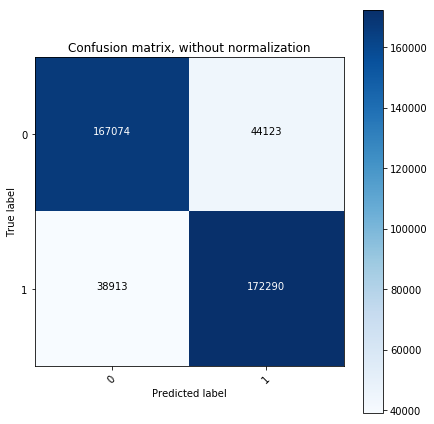

0.8034183853635513

In [48]:
evaluations = text_classifier_reloaded.evaluate(valid)
evaluations.plot_confusion_matrix(normalize=False,
                                title='Confusion matrix, without normalization', 
                                print_confusion_matrix=False,
                                figsize=(6,6),
                                colors=None)
evaluations.get_metrics('micro_avg_accuracy')
evaluations.get_metrics('macro_avg_accuracy')